# 3D Wind Retrievals

In [1]:
%env ARTS_INCLUDE_PATH=/home/simonpf/src/arts/controlfiles/
%env ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
%env ARTS_BUILD_PATH=/home/simonpf/build/arts/

import sys
sys.path.append("..")
sys.path.append("/home/simonpf/src/typhon/")
import utils.setup

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from typhon.arts.workspace import Workspace, arts_agenda

env: ARTS_INCLUDE_PATH=/home/simonpf/src/arts/controlfiles/
env: ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
env: ARTS_BUILD_PATH=/home/simonpf/build/arts/


Loading ARTS API from: /home/simonpf/build/arts/src/libarts_api.so


This notebook is essentially a transcript of the `qpack_wind3d_demo.m` script which uses a
three-dimensional atmosphere to retrieve wind speeds.

In [2]:
ws = Workspace()

ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/planet_earth.arts")

ws.Copy(ws.abs_xsec_agenda,   ws.abs_xsec_agenda__noCIA)
ws.Copy(ws.ppath_agenda,      ws.ppath_agenda__FollowSensorLosPath)
ws.Copy(ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath)
ws.Copy(ws.iy_space_agenda,   ws.iy_space_agenda__CosmicBackground)
ws.Copy(ws.iy_surface_agenda, ws.iy_surface_agenda__UseSurfaceRtprop)
ws.Copy(ws.iy_main_agenda,    ws.iy_main_agenda__Emission)
ws.Copy(ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__OnTheFly)

ARTS[36471216]: Executing /home/simonpf/src/arts/controlfiles/general/general.arts
ARTS[36471216]: {
ARTS[36471216]: - verbosityInit
ARTS[36471216]: - scat_speciesSet
ARTS[36471216]: - MatrixSet
ARTS[36471216]: - Tensor4SetConstant
ARTS[36471216]: - ArrayOfStringSet
ARTS[36471216]: - Touch
ARTS[36471216]: - MatrixSet
ARTS[36471216]: - NumericSet
ARTS[36471216]: - ArrayOfStringSet
ARTS[36471216]: - Tensor3SetConstant
ARTS[36471216]: - Tensor3SetConstant
ARTS[36471216]: - Tensor3SetConstant
ARTS[36471216]: - Tensor3SetConstant
ARTS[36471216]: - Tensor3SetConstant
ARTS[36471216]: - Tensor3SetConstant
ARTS[36471216]: - IndexSet
ARTS[36471216]: - IndexSet
ARTS[36471216]: - IndexSet
ARTS[36471216]: - IndexSet
ARTS[36471216]: - FlagOff
ARTS[36471216]: - output_file_formatSetAscii
ARTS[36471216]: - StringSet
ARTS[36471216]: - IndexSet
ARTS[36471216]: - abs_lineshapeDefine
ARTS[36471216]: - NumericSet
ARTS[36471216]: - NumericSet
ARTS[36471216]: - AgendaSet
ARTS[36471216]: - IndexSet
ARTS[36471

## General Settings

For the wind retrievals, the forward model calculations are performed on a 3D atmosphere grid.
Radiation is assumed to be unpolarized.

In [3]:
ws.atmosphere_dim = 3
ws.stokes_dim     = 1
ws.iy_unit = "RJBT"

## Absorption

We only consider absorption from ozone in this example. The lineshape data is available from
the ARTS testdata available in `controlfiles/testdata`.

In [4]:
ws.abs_speciesSet(["O3", "H2O-PWR98"])
ws.abs_lineshapeDefine("Voigt_Kuntz6", "VVH", 750e9)
ws.ReadXML(ws.abs_lines, "testdata/ozone_line.xml")
ws.abs_lines_per_speciesCreateFromLines()

## Atmosphere (A Priori)

We create a pressure grid using the `PFromZSimple` function to create a grid of approximate pressure levels corresponding to altitudes in the range

$$
z = 0.0, 2000.0, \dots, 94000.0
$$

In [5]:
z_toa  = 95e3;
z_surf = 1e3;
z_grid = np.arange(z_surf - 1e3, z_toa, 2e3)
ws.PFromZSimple(ws.p_grid, z_grid)
ws.lat_grid = np.arange(-40.0, 1.0, 40.0)
ws.lon_grid = np.arange(40.0, 61.0, 20.0)
ws.z_surface = z_surf * np.ones((np.asarray(ws.lat_grid).size,
                                 np.asarray(ws.lon_grid).size))

For the a priori state we read data from the Fascod climatology that is part of the ARTS xml data.

In [6]:
ws.AtmRawRead(basename = "planets/Earth/Fascod/tropical/tropical")
ws.AtmFieldsCalcExpand1D()

## Adding Wind

Wind in ARTS is represented by the `wind_u_field` and `wind_v_field` WSVs, which hold the horizontal components of the wind at each grid point of the atmosphere model. For this example, a constant wind is assumed.

In [37]:
u_wind = 60.0
v_wind = -40.0
ws.wind_u_field = u_wind * np.ones((ws.p_grid.value.size,
                                    ws.lat_grid.value.size,
                                    ws.lon_grid.value.size))
ws.wind_v_field = v_wind * np.ones((ws.p_grid.value.size,
                                    ws.lat_grid.value.size,
                                    ws.lon_grid.value.size))
ws.wind_w_field = np.zeros((0,0,0))

## Frequency Grid and Sensor

The frequency grid for the simulation consists of 119 grid
points between 110.516 and 111.156 GHz. The frequencies
are given by a degree-10 polynomial that has been obtained from a fit to the data from the original `qpack` example. This is obscure but also kind of cool.

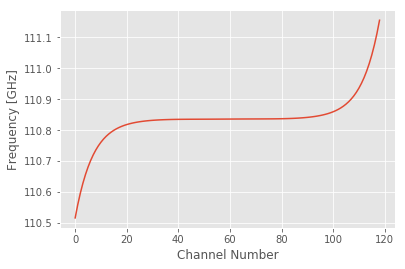

In [38]:
coeffs = np.array([5.06312189e-08, -2.68851772e-05, 6.20655463e-03,
                   -8.16344090e-01,   6.75337174e+01,  -3.66786505e+03,
                   1.32578167e+05,  -3.14514304e+06,   4.57491354e+07,
                   1.10516484e+11])
ws.f_grid = np.poly1d(coeffs)(np.arange(119))

plt.plot(ws.f_grid.value * 1e-9)
plt.xlabel("Channel Number")
plt.ylabel("Frequency [GHz]")



For the sensor we assume a channel width and channel spacing of 50 kHz. We also call `AntennaOff` to compute
only one pencilbeam along the line of sight of the sensor.

In [39]:
df = 50e3
f_backend = np.arange(ws.f_grid.value.min() + 2.0 * df, ws.f_grid.value.max() - 2.0 * df, df)
ws.backend_channel_responseGaussian(np.array([df]), np.array([2.0]))
ws.AntennaOff()

ws.sensor_norm = 1
ws.sensor_time = np.zeros(1)
ws.sensor_responseInit()

### Sensor Position and Viewing Geometry

5 Measurements are performed, one straight up, and four with zenith angle $70^\circ$ in directions SW, NW, NE, SE. In ARTS the measurement directions are given by a two-column matrix, where the first column contains the zenith angle and the second column the azimuth angle.

In [40]:
ws.sensor_los = np.array([[0.0, 0.0,],
                          [70.0, -135.0],
                          [70.0, -45.0],
                          [70.0, 45.0],
                          [70.0, 135.0]])
ws.sensor_pos = np.array([[2000.0, -21.1, 55.6]] * 5)

## Reference Measurement

Before we can calculate `y`, our setup needs to pass the following tests:

In [41]:
ws.abs_f_interp_order = 3
ws.propmat_clearsky_agenda_checkedCalc()
ws.sensor_checkedCalc()
ws.atmgeom_checkedCalc()
ws.atmfields_checkedCalc()
ws.abs_xsec_agenda_checkedCalc()
ws.cloudboxOff()
ws.jacobianOff()
ws.cloudbox_checkedCalc()

Now, we can run the simulation using the `yCalc` WSM and display the results. The results for all 5 measurements are stacked in `ws.y`.

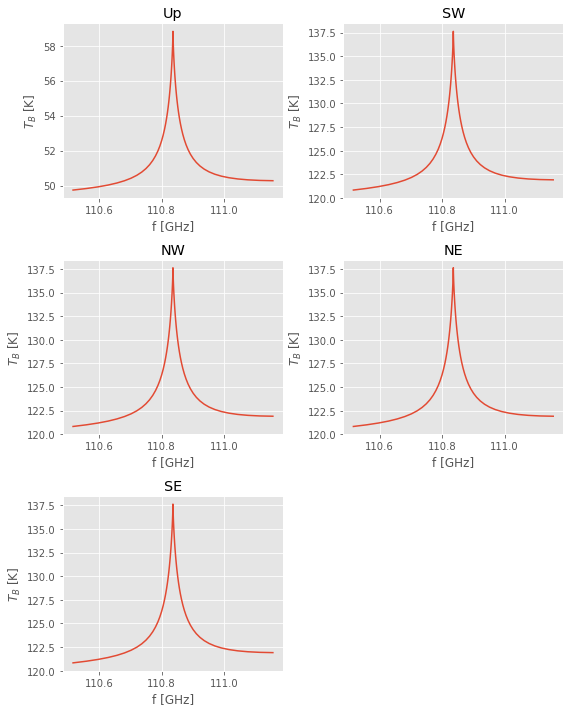

In [42]:
ws.yCalc()

from matplotlib.colors import Normalize

labels = ["Up", "SW", "NW", "NE", "SE"]
f, axs = plt.subplots(3,2, figsize=(8,10))
n_meas = ws.y.value.size // 5

freqs = ws.f_grid.value
z     = ws.z_field.value[:, 0, 0].ravel()
norm  = Normalize(vmin = 0.0, vmax = 1.5)

for i in range(6):
    ax = axs.ravel()[i]
    if i < 5:
        i_start = n_meas * i
        i_end   = n_meas * (i + 1)
        y = ws.y.value[i_start:i_end]
        ax.plot(freqs / 1e9, y)
        ax.set_title(labels[i])
        ax.set_xlabel("f [GHz]")
        ax.set_ylabel("$T_B$ [K]")
    else:
        ax.axis("off")
plt.tight_layout()

## Setting up the Retrieval

In this example, we retrieve ozone and the horizontal and vertical components of the wind velocities. The state space covariance matrix in ARTS is represented by the **covmat_sa** WSV. It belongs to the CovarianceMatrix group, which is used to represent block diagonal matrices. For each retrieval quantity that is added to the retrieval, a corresponding block must be added to **covmat_sa**. This is usually done by the corresponding **retrievalAdd...** call, which looks for this block in the **covmat_block** WSV.

In short the general workflow for adding a retrieval quantity is as follows:

- Create the covariance matrix for the retrieval quantity either calling one of the **covmat...**
  WSV or by loading your own matrix
- Write the matrix block into **covmat_block**
- Call the **retrievalAdd...** method to add the retrieval quantity and the covariance matrix block
  to **covmat_sa**

In [43]:
lat_ret_grid = np.array([np.mean(ws.lat_grid)])
lon_ret_grid = np.array([np.mean(ws.lon_grid)])
n_p = ws.p_grid.value.size

ws.retrievalDefInit()
ws.covmat1D(ws.covmat_block,
            grid_1 = z_grid,
            sigma_1 = 0.1  * np.ones(n_p), # Relative uncertainty
            cls_1   = 10e3 * np.ones(n_p), # 10km correlation length
            fname   = "lin")
ws.retrievalAddAbsSpecies(species = "O3",
                          unit    = "rel",
                          g1      = ws.p_grid,
                          g2      = lat_ret_grid,
                          g3      = lon_ret_grid)
# Wind u-component
ws.covmat1D(ws.covmat_block,
            grid_1 = z_grid[::2],
           sigma_1 = 100.0  * np.ones(n_p // 2), # Relative uncertainty
           cls_1   = 10e3 * np.ones(n_p // 2), # 10km correlation length
           fname   = "lin")
ws.retrievalAddWind(g1 = ws.p_grid.value[::2],
                    g2 = np.array([np.mean(ws.lat_grid)]),
                    g3 = np.array([np.mean(ws.lon_grid)]),
                    component = "u")
# Wind v-component
ws.covmat1D(ws.covmat_block,
            grid_1 = z_grid[::2],
           sigma_1 = 100.0  * np.ones(n_p // 2), # Relative uncertainty
           cls_1   = 10e3 * np.ones(n_p // 2), # 10km correlation length
           fname   = "lin")
ws.retrievalAddWind(g1 = ws.p_grid.value[::2],
                    g2 = np.array([np.mean(ws.lat_grid)]),
                    g3 = np.array([np.mean(ws.lon_grid)]),
                    component = "v")
ws.retrievalDefClose()
ws.covmatDiagonal(ws.covmat_block, ws.covmat_inv_block, vars = 0.0001 * np.ones(ws.y.value.shape))
ws.covmat_seSet(ws.covmat_block)

In [44]:
@arts_agenda
def inversion_iterate_agenda(ws):
    ws.x2artsStandard()  
    ws.atmfields_checkedCalc()
    ws.atmgeom_checkedCalc()
    ws.yCalc()
    ws.Print(ws.y)
    ws.Print(ws.jacobian)
    ws.VectorAddVector( ws.yf, ws.y, ws.y_baseline )
    
ws.Copy(ws.inversion_iterate_agenda, inversion_iterate_agenda)

## Jacobians

We plot the Jacobians w.r.t. to the different retrieval quantities to check that we are sensitive to them.

In [45]:
ws.jacobian_do = 1
ws.yCalc()
y = np.copy(ws.y.value)

### Ozone

/home/simonpf/build/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


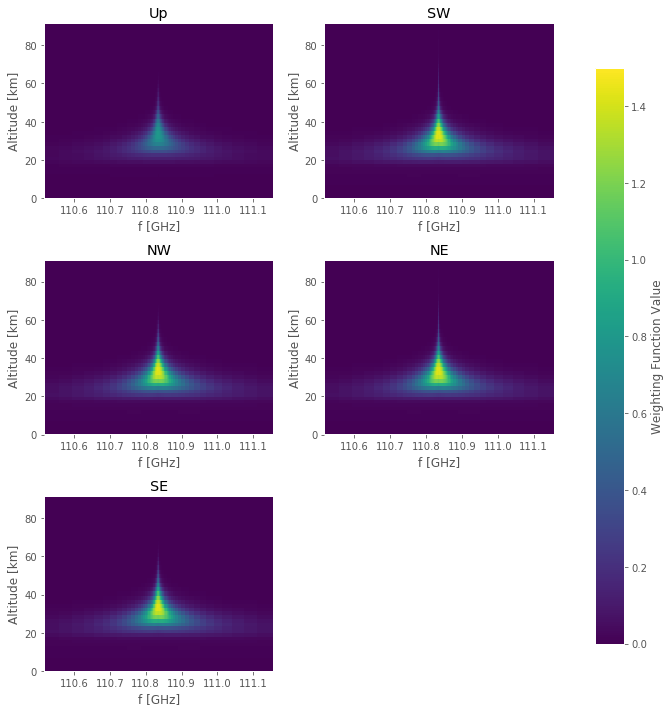

In [46]:
from matplotlib.colors import Normalize

f, axs = plt.subplots(3,2, figsize=(8,10))
n_meas = ws.y.value.size // 5

freqs = ws.f_grid.value
z     = ws.z_field.value[:, 0, 0].ravel()
norm  = Normalize(vmin = 0.0, vmax = 1.5)

for i in range(6):
    ax = axs.ravel()[i]
    if i < 5:
        i_start = n_meas * i
        i_end   = n_meas * (i + 1)
        j = ws.jacobian.value[i_start:i_end, :n_p]
        
        im = axs.ravel()[i].pcolormesh(freqs / 1e9, z / 1e3, j.T, norm = norm)
        ax.set_title(labels[i])
        ax.set_xlabel("f [GHz]")
        ax.set_ylabel("Altitude [km]")
    else:
        ax.axis("off")
cax = f.add_axes([1.04, 0.1, 0.05, 0.8])        
cbax = f.colorbar(im, cax = cax,
                  label = "Weighting Function Value", norm = norm)        
plt.tight_layout()

## Zonal Winds

For zonal winds we plot the logarithm of the absolute value to visualize the different sensitivity scales throughout the model atmosphere.

/home/simonpf/build/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


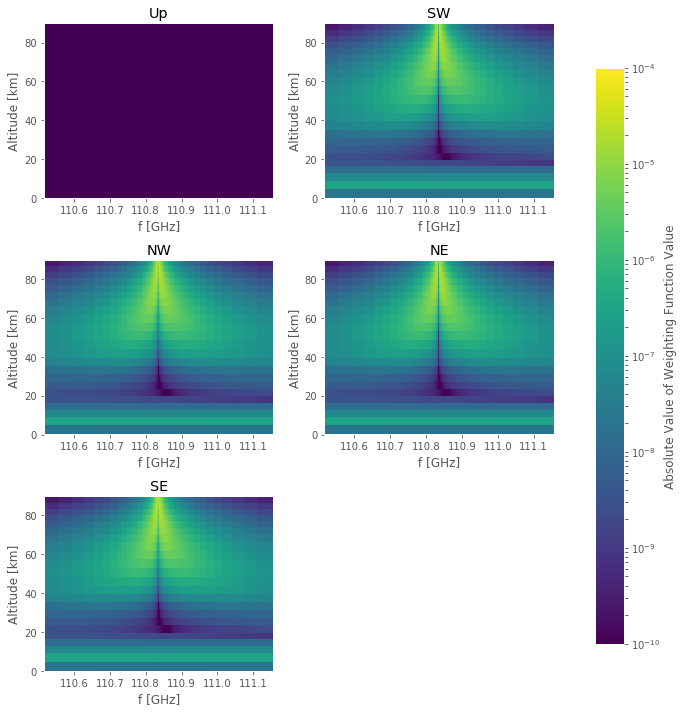

In [47]:
from matplotlib.colors import LogNorm

f, axs = plt.subplots(3, 2, figsize=(8, 10))
n_meas = ws.y.value.size // 5
norm = LogNorm(vmin = 1e-10, vmax = 1e-4)

for i in range(6):
    ax = axs.ravel()[i]
    if i < 5:
        i_start = n_meas * i
        i_end   = n_meas * (i + 1)
        j = ws.jacobian.value[i_start:i_end, n_p: 3 * n_p // 2]
        
        im = axs.ravel()[i].pcolormesh(freqs / 1e9, z[::2 ] / 1e3, np.abs(j.T), norm = norm)
        ax.set_title(labels[i])
        ax.set_xlabel("f [GHz]")
        ax.set_ylabel("Altitude [km]")
    else:
        ax.axis("off")
cax = f.add_axes([1.04, 0.1, 0.05, 0.8])        
cbax = f.colorbar(im, cax = cax,
                  label = "Absolute Value of Weighting Function Value", norm = norm)        
plt.tight_layout()

## Meridional Winds

/home/simonpf/build/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


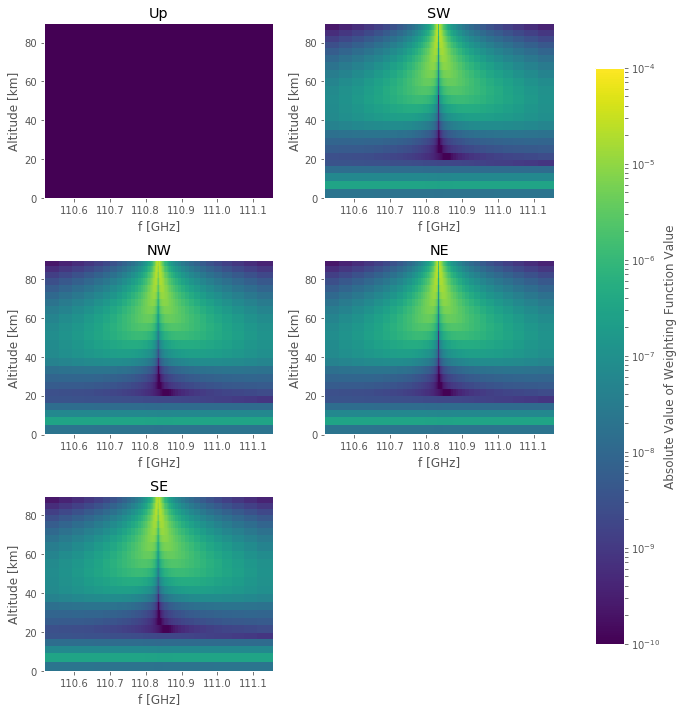

In [48]:
f, axs = plt.subplots(3, 2, figsize=(8, 10))
norm   = LogNorm(vmin = 1e-10, vmax = 1e-4)

for i in range(6):
    ax = axs.ravel()[i]
    if i < 5:
        i_start = n_meas * i
        i_end   = n_meas * (i + 1)
        j = ws.jacobian.value[i_start:i_end, 3 * (n_p // 2): 5 * (n_p // 2)]
        
        im = axs.ravel()[i].pcolormesh(freqs / 1e9, z[::2 ] / 1e3, np.abs(j.T), norm = norm)
        ax.set_title(labels[i])
        ax.set_xlabel("f [GHz]")
        ax.set_ylabel("Altitude [km]")
    else:
        ax.axis("off")
cax = f.add_axes([1.04, 0.1, 0.05, 0.8])        
cbax = f.colorbar(im, cax = cax,
                  label = "Absolute Value of Weighting Function Value", norm = norm)        
plt.tight_layout()

## A Priori State

For the a priori state we assume zero wind in any direction. The a priori vector for the OEM is created by the `xaStandard` WSM, which computes $x_a$ from the current atmospheric state.

In [49]:
ws.wind_u_field.value[:] = 0.0
ws.wind_v_field.value[:] = 0.0
ws.xaStandard()

## The OEM Calculation

In [50]:
ws.x        = np.zeros(0)
ws.jacobian = np.zeros((0,0))
ws.y.value[:] = y
ws.OEM(method="lm", max_iter=20, display_progress=1,
       lm_ga_settings=np.array([100.0,2.0,2.0,10.0,1.0,1.0]))


ARTS[36471216]: 
ARTS[36471216]:                                 MAP Computation                                
ARTS[36471216]: Formulation: Standard
ARTS[36471216]: Method:      Levenberg-Marquardt
ARTS[36471216]: 
ARTS[36471216]:  Step     Total Cost         x-Cost         y-Cost    Conv. Crit.   Gamma Factor
ARTS[36471216]: --------------------------------------------------------------------------------
ARTS[36471216]:     0        1.88092              0        1.88092                    100.000000
ARTS[36471216]:     1      0.0321098    0.000966816      0.0311429         10.203      50.000000
ARTS[36471216]:     2      0.0105809     0.00138166      0.0091992      0.0614192      25.000000
ARTS[36471216]:     3     0.00441688     0.00178634     0.00263053      0.0164098      12.500000
ARTS[36471216]:     4     0.00309746     0.00205835     0.00103912     0.00395287       6.250000
ARTS[36471216]:     5     0.00275193     0.00220829    0.000543639    0.000750297       3.125000
ARTS[36

In [51]:
ws.x2artsStandard()

## Retrieval Results

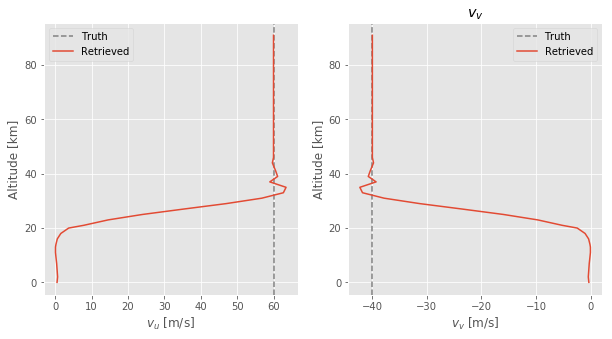

In [52]:
f, axs = plt.subplots(1, 2, figsize = (10, 5))

ax = axs[0]
ax.axvline(u_wind, color = "grey", ls = "--", label = "Truth")
ax.plot(ws.wind_u_field.value[:, 0, 0], z // 1e3, label = "Retrieved")
ax.set_xlabel("$v_u$ [m/s]")
ax.set_ylabel("Altitude [km]")
ax.legend()

ax = axs[1]
ax.axvline(v_wind, color = "grey", ls = "--", label = "Truth")
ax.plot(ws.wind_v_field.value[:, 0, 0], z // 1e3, label = "Retrieved")
ax.set_title("$v_v$")
ax.set_xlabel("$v_v$ [m/s]")
ax.set_ylabel("Altitude [km]")
ax.legend()